In [1]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn  
import pandas as pd  
import pickle  
from keras import layers  
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout  
from keras.models import Sequential, Model, load_model  
from keras.preprocessing import image  
from keras.preprocessing.image import load_img  
from keras.preprocessing.image import img_to_array  
from keras.applications.imagenet_utils import decode_predictions  
from keras.utils import layer_utils, np_utils  
from keras.utils.data_utils import get_file  
from keras.applications.imagenet_utils import preprocess_input  
from keras.utils.vis_utils import model_to_dot  
from keras.utils import plot_model  
from keras.initializers import glorot_uniform  
from keras import losses  
import keras.backend as K  
from keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, classification_report  
import tensorflow as tf
import os
import os.path

Using TensorFlow backend.


In [2]:
# Ruta de la imagen y extensiones válidas.
imageDir = 'D:/Competicion/WIDS/train_images/' #Especific tu ruta aqui
image_path_list = []
valid_image_extensions = [".jpg", ".jpeg", ".png", ".tif", ".tiff"] # Especifique sus extensiones vald aquí
valid_image_extensions = [item.lower() for item in valid_image_extensions]

# Crear una lista de todos los archivos en el directorio y
# Adjuntar archivos con una extensión válida a la lista image_path
for file in os.listdir(imageDir):
    extension = os.path.splitext(file)[1]
    if extension.lower() not in valid_image_extensions:
        continue
    image_path_list.append(os.path.join(imageDir, file))

# close any open windows
cv2.destroyAllWindows()

In [3]:
images = []
for value in image_path_list:
    images.append(value.split('/')[4])

In [4]:
orden_image = pd.DataFrame({'image_id':images,'orden':range(15244)})

In [5]:
np.shape(image_path_list)

(15244,)

In [6]:
x_train_original = np.empty((15244, 256, 256, 3), dtype=np.uint8)
for i, fpath in enumerate(image_path_list):
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    x_train_original[i, ...] = img.transpose(0, 1, 2)

In [7]:
x_train_original.shape

(15244, 256, 256, 3)

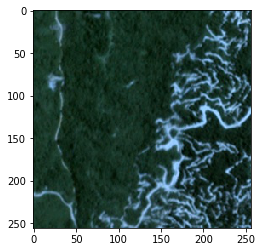

In [8]:
imgplot = plt.imshow(x_train_original[1])
plt.show()

**Cargando Labels en DataFrame**

In [9]:
y_train_original = pd.read_csv('D:/Competicion/WIDS/traininglabels.csv',sep = ',')

In [10]:
y_train_original = y_train_original.merge(orden_image)

In [11]:
y_train_original.sort_values(by = 'orden', ascending = True, inplace = True)

In [12]:
y_tot = pd.DataFrame({'has_oilpalm':y_train_original['has_oilpalm'].values,'orden':y_train_original['orden']})

In [13]:
len(y_tot['has_oilpalm'])

15244

In [14]:
sum(y_tot['has_oilpalm'])

942

**Sacando Train,Test - Metodo 2**

In [15]:
import random 
c = range(15244)
sample = random.sample(c,12195)
sample_train = []
sample_test = []
for m in c:
    if m in sample:
        sample_train.append(m)
    else:
        sample_test.append(m)

In [16]:
sample_test_data = pd.DataFrame({'orden':sample_test,'tipo_base':'data_Test'})
sample_train_data = pd.DataFrame({'orden':sample_train,'tipo_base':'data_Train_total'})

In [17]:
y_validation = y_tot.merge(sample_test_data)
len(y_validation)

3049

In [18]:
y_train_test = y_tot.merge(sample_train_data,how = 'right')
len(y_train_test)

12195

In [19]:
del m
c_tr = range(12195)
sample_tr = random.sample(c_tr,2439)
sample_train = []
sample_val_tot = []
for m in c_tr:
    if m in sample_tr:
        sample_train.append(m)
    else:
        sample_val_tot.append(m)

In [20]:
sample_train_data = pd.DataFrame({'orden2':sample_train,'tipo_base2':'data_train'})
sample_valtot_data = pd.DataFrame({'orden2':sample_val_tot,'tipo_base2':'data_val_tot'})

In [21]:
y_train_test['orden2'] = range(12195)

In [22]:
y_train_prev = y_train_test.merge(sample_train_data)
len(y_train_prev)

2439

In [23]:
y_val_total = y_train_test.merge(sample_valtot_data,how = 'right')
len(y_val_total)

9756

In [24]:
del m
c_val = range(9756)
sample_val = random.sample(c_val,2134)
sample_validation = []
for m in c_val:
    if m in sample_val:
        sample_validation.append(m)

In [25]:
sample_validation_data = pd.DataFrame({'orden3':sample_validation,'tipo_base3':'data_validation'})

In [26]:
y_val_total['orden3'] = range(9756)

In [27]:
y_test_prev = y_val_total.merge(sample_validation_data)
len(y_test_prev)

2134

In [28]:
y_train = pd.DataFrame({'has_oilpalm':y_train_prev['has_oilpalm'],'orden':y_train_prev['orden']})
y_train = np_utils.to_categorical(y_train['has_oilpalm'], 2)
y_train.shape

(2439, 2)

In [29]:
y_test = pd.DataFrame({'has_oilpalm':y_test_prev['has_oilpalm'],'orden':y_test_prev['orden']})
y_test = np_utils.to_categorical(y_test['has_oilpalm'], 2)
y_test.shape

(2134, 2)

In [30]:
data_train = list(y_train_prev['orden'])
data_test = list(y_test_prev['orden'])

In [31]:
x_train = (x_train_original[data_train] / 255)
x_train.shape

(2439, 256, 256, 3)

In [32]:
x_test = (x_train_original[data_test] / 255)
x_test.shape

(2134, 256, 256, 3)

In [33]:
K.set_image_data_format('channels_last')

In [34]:
K.set_learning_phase(1)

In [41]:
from keras.applications import vgg16

def create_vgg16():
    model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(256,256,3), pooling=None, classes=2)
    
    return model

In [42]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse']) 

In [43]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [44]:
vgg16 = vgg16_model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, verbose=1, validation_data=(x_test, y_test), shuffle=True)

Train on 2439 samples, validate on 2134 samples
Epoch 1/5
 160/2439 [>.............................] - ETA: 1:24:50 - loss: 0.6774 - acc: 0.7438 - mean_squared_error: 0.2421

KeyboardInterrupt: 